In [7]:
#Importing libraries

import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm 
import re

#Preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#Metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Samplers
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

pd.set_option("display.max_columns", None)

# 1. Exploratory Data Analysis

Let's start by loading the training and test datasets. 
<br>The csv files do not contain the headers so we add them for more readability. 
<br>Also, as mentioned in the metadata, column 24 (instance weight) should not be used for classification.

In [8]:
#Downloading data
!wget http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip

--2020-11-03 21:29:26--  http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip
Résolution de thomasdata.s3.amazonaws.com (thomasdata.s3.amazonaws.com)… 52.216.145.51
Connexion à thomasdata.s3.amazonaws.com (thomasdata.s3.amazonaws.com)|52.216.145.51|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 9801875 (9,3M) [application/zip]
Sauvegarde en : « us_census_full.zip.1 »

us_census_full.zip. 100%[===================>]   9,35M  2,55MB/s    ds 4,0s    

2020-11-03 21:29:30 (2,34 MB/s) — « us_census_full.zip.1 » sauvegardé [9801875/9801875]



In [7]:
#Unziping
!unzip us_census_full.zip

Archive:  us_census_full.zip
   creating: us_census_full/
  inflating: us_census_full/census_income_learn.csv  
  inflating: us_census_full/census_income_metadata.txt  
  inflating: us_census_full/census_income_test.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._us_census_full  


In [9]:
#Loading dataset
train = pd.read_csv('./us_census_full/census_income_learn.csv', header=None)
test = pd.read_csv('./us_census_full/census_income_test.csv', header=None)

In [10]:
#Getting headers
with open('./us_census_full/census_income_metadata.txt') as f:
    headers = [re.findall((r'\(.*?\)'), line)[0].replace('(', '').replace(')', '')
               for i, line in enumerate(f) if i in range(81, 121)]
    
headers.insert(24,'instance weight')
headers.append('income')

print(headers)

['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'instance weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admin", 'veterans benefits', 'week

In [11]:
train.columns = headers
test.columns = headers

train.drop(['instance weight'], axis=1, inplace=True)
test.drop(['instance weight'], axis=1, inplace=True)

print(f'Train set shape: {train.shape}')
print(f'Test set shape: {test.shape}')

Train set shape: (199523, 41)
Test set shape: (99762, 41)


We have around 200k training instances and 100k test instances.
<br>The datasets contain 41 features including the target class (income)

In [12]:
train.head(5)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


## Data cleaning

The data missing values in the data set are represented by ' ?'
<br>We replace them by NaN and check for missing values in the dataset.

In [13]:
train.replace(' ?', np.nan, inplace=True)
test.replace(' ?', np.nan, inplace=True)

#Checking missing values
print(train.isna().sum())
print(test.isna().sum())

age                                               0
class of worker                                   0
detailed industry recode                          0
detailed occupation recode                        0
education                                         0
wage per hour                                     0
enroll in edu inst last wk                        0
marital stat                                      0
major industry code                               0
major occupation code                             0
race                                              0
hispanic origin                                   0
sex                                               0
member of a labor union                           0
reason for unemployment                           0
full or part time employment stat                 0
capital gains                                     0
capital losses                                    0
dividends from stocks                             0
tax filer st

Some columns have a lot of missing values (country of birth father, migration code, etc.) but the rest of the columns doesn't have any.
<br>We will deal with misssing values after we drop the columns that we don't need for our analysis.

Checking for duplicated and conflicting instances in the datasets.

In [14]:
#Printing number of duplicate instances
print('Number of duplicates in the training set: {} ({:.2f}%)'.format(train.duplicated().sum(), 100*train.duplicated().sum()/len(train)))
print('Number of duplicates in the test set: {} ({:.2f}%)'.format(test.duplicated().sum(), 100*test.duplicated().sum()/len(test)))

Number of duplicates in the training set: 46627 (23.37%)
Number of duplicates in the test set: 20898 (20.95%)


In [15]:
#Dropping duplicates
train.drop_duplicates(inplace=True)
train.reset_index(inplace=True, drop=True)

test.drop_duplicates(inplace=True)
test.reset_index(inplace=True, drop=True)

Replacing target feature (income) values to binary class values. 
- \-50000 : 0
- +50000 : 1

Renaming class to "more than 50k".

In [16]:
#Mapping class to binary class values
class_mapping = {train['income'].value_counts().index[0]: 0,
                 train['income'].value_counts().index[1]: 1,}
print(class_mapping)

train['income'].replace(class_mapping, inplace=True)
test['income'].replace(class_mapping, inplace=True)

#Renaming target feature
train.rename(columns={"income": "more than 50k"}, inplace=True)
test.rename(columns={"income": "more than 50k"}, inplace=True)

{' - 50000.': 0, ' 50000+.': 1}


In [17]:
#Checking columns type
train.dtypes

age                                            int64
class of worker                               object
detailed industry recode                       int64
detailed occupation recode                     int64
education                                     object
wage per hour                                  int64
enroll in edu inst last wk                    object
marital stat                                  object
major industry code                           object
major occupation code                         object
race                                          object
hispanic origin                               object
sex                                           object
member of a labor union                       object
reason for unemployment                       object
full or part time employment stat             object
capital gains                                  int64
capital losses                                 int64
dividends from stocks                         

Most features are categorical.
The goal of this analysis is to predict whether or not a person earns more than 50k, and to determine the impact of the other attributes.
<br>We can intuitively remove some features that are irrelant for our case or redundant with other features.
- **detailed industry recode**: even though this feature provides more precise information than major industy code, we remove this variable and only keep the latter to avoid redundancies
- **detailed occupation recode**: likewise with major occupation code, we remove this variable and keep major occupation code
- **enroll in edu inst last wk**: redundant with education
- **hispanic origin**: not needed because we have the race feature
- **member of a labor union**: not needed/irrelevant
- **reason for unemployment**: not needed/irrelevant
- **tax filler stat**: not needed/irrelevant
- **region of previous residence**: not needed/irrelevant
- **detailed household and family stat**: not needed/irrelevant
- **summary household and family stat**: not needed/irrelevant
- **migration code-change in msa**: many missing values, not needed/irrelevant
- **migration code-change in reg**: idem
- **migration code-move in reg**: idem
- **live in this house 1 year ago**: not needed/irrelevant
- **migration prev res in sunbelt**: not needed/irrelevant
- **num persons worked for employer**: not needed/irrelevant
- **family members under 18**: not needed/irrelevant
- **country of birth father**: we keep citizenship and race instead
- **country of birth mother**: we keep citizenship and race instead
- **country of birth self**: we keep citizenship and race instead
- **own business or self employed**: not needed/irrelevant
- **fill enc questionnaire for veteran's admin**: not needed/irrelevant
- **veterans benefits**: not needed/irrelevant
- **year**: not needed/irrelevant

In [18]:
#Dropping attributes that we don't need
cols_to_drop = ['detailed industry recode', 'detailed occupation recode', 
                'enroll in edu inst last wk',
               'hispanic origin', 'member of a labor union', 
                'reason for unemployment', 'full or part time employment stat',
                'tax filer stat', 'region of previous residence',
               'state of previous residence', 'detailed household and family stat',
               'detailed household summary in household', 'migration code-change in msa',
               'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago',
               'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18',
               'country of birth father', 'country of birth mother', 'own business or self employed',
               'fill inc questionnaire for veteran\'s admin', 'veterans benefits', 'year']

train.drop(columns=cols_to_drop, axis=1, inplace=True)
test.drop(columns=cols_to_drop, axis=1, inplace=True)

## Visualising the data

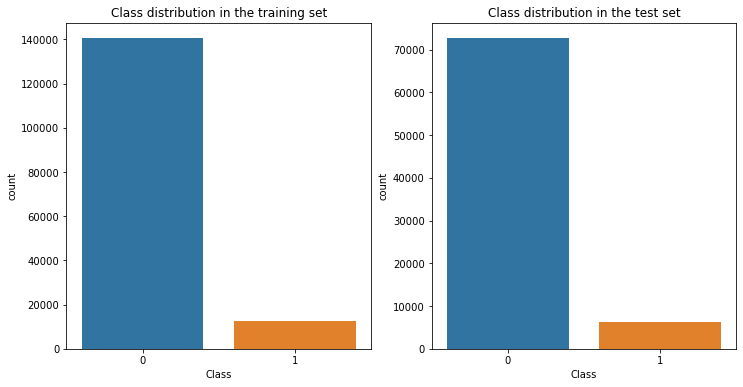

Proportion of class 1 in the training set: 8.09%
Proportion of class 1 in the test set: 7.84%


In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
sns.countplot(ax=ax1, x='more than 50k', data=train)
ax1.set(title='Class distribution in the training set', xlabel='Class')


sns.countplot(ax=ax2, x='more than 50k', data=test)
ax2.set(title='Class distribution in the test set', xlabel='Class')
plt.show()

#Printing class distribution in the datasets

print('Proportion of class 1 in the training set: {:.2f}%'.format(100*train['more than 50k'].mean()))
print('Proportion of class 1 in the test set: {:.2f}%'.format(100*test['more than 50k'].mean()))

Most of the records are in class 0. 
<br>The dataset is imbalanced. We will see how to handle this issue further in the analysis.

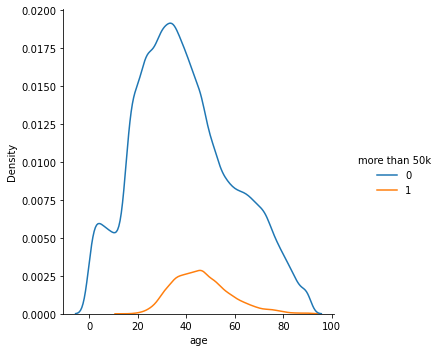

In [31]:
sns.displot(data=train, x='age', hue='more than 50k', kind='kde')

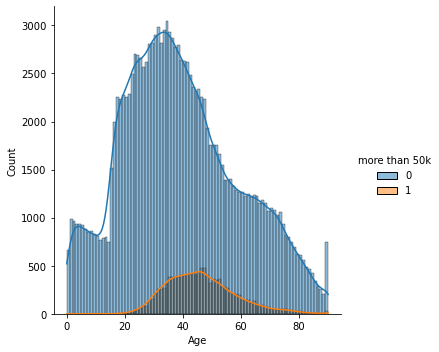

In [33]:
#Plotting the age distribution by class

#deprecated in future versions
#ax = sns.FacetGrid(train, col='more than 50k', height=5)
#ax = ax.map(sns.distplot, "age")

ax = sns.displot(data=train, x='age', hue='more than 50k', kde=True)
ax.set(xlabel='Age')
plt.show()

This plot shows that the age of the people earning less than 50k is more spread out (higher stantard deviation) than the age of those earing more than 50k. Moreover the average age of people earning more than 50k is higher than the average age of people earning less than 50k.

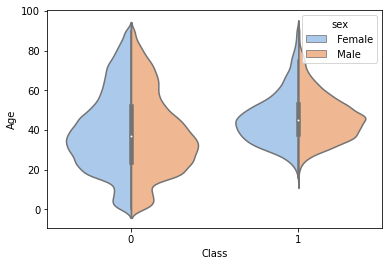

In [14]:
#Plotting the age distribution by age and sex

ax = sns.violinplot(x='more than 50k' , y='age', hue='sex', 
               data=train, split=True, palette='pastel')
ax.set(xlabel='Class', ylabel='Age')
plt.show()

Likewise, this plot shows the distribution of age by class and also by gender. There is no notable difference of the age distribution by gender within a class.

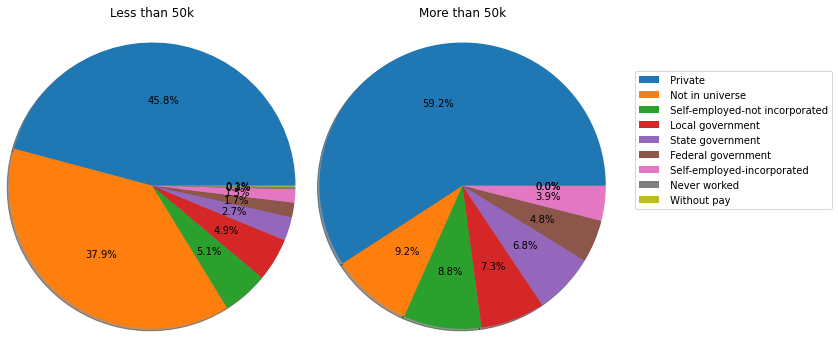

In [34]:
#Plotting the class of worker distribution by class

df_class1 = train[train['more than 50k'] == 1]['class of worker']
counts_class1 = df_class1.value_counts()

df_class0 = train[train['more than 50k'] == 0]['class of worker']
counts_class0 = df_class0.value_counts()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,15))

ax1.pie(counts_class0, shadow=True, autopct='%1.1f%%', radius=1.5, labeldistance=1.05)
ax1.set_title("Less than 50k", loc='center', pad=50)

ax2.pie(counts_class1, shadow=True, autopct='%1.1f%%', radius=1.5)
ax2.legend(labels=counts_class0.index, bbox_to_anchor=(1.2,1.0))
ax2.set_title("More than 50k", loc='center', pad=50)

plt.tight_layout()
plt.show()

This plot shows that among people earning more than 50k, most are from the private sector, whereas among those who earn less than 50k, the vast majority is either from the private sector or self-employed-incorporated.

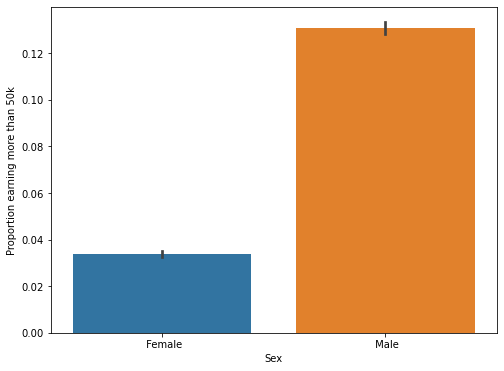

In [17]:
#Plotting the proportion of people earning more than 50k by gender

chart, ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(x='sex', y='more than 50k', data=train)
ax.set(xlabel='Sex', ylabel='Proportion earning more than 50k')
plt.show()

This histogram shows that the proportion of male earning more than 50k is a lot higher than the proportion of female earning more than 50k.

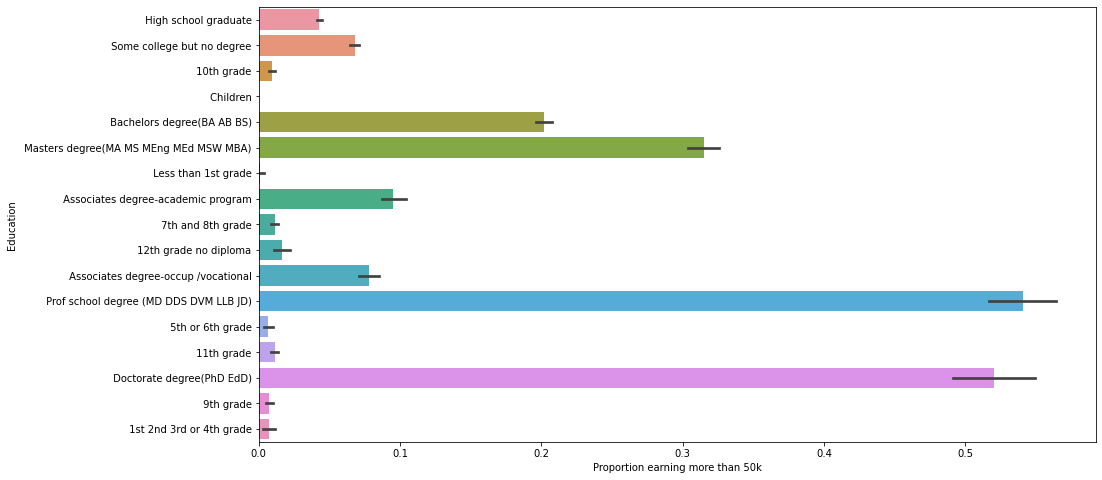

In [35]:
#Proportion earning more than 50k by level of education

chart, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(y='education', x='more than 50k', data=train)
ax.set(ylabel='Education', xlabel='Proportion earning more than 50k')
plt.show()

Likewise, the level of education seems to have a very big influence on the whether someone earns more than 50k or not.

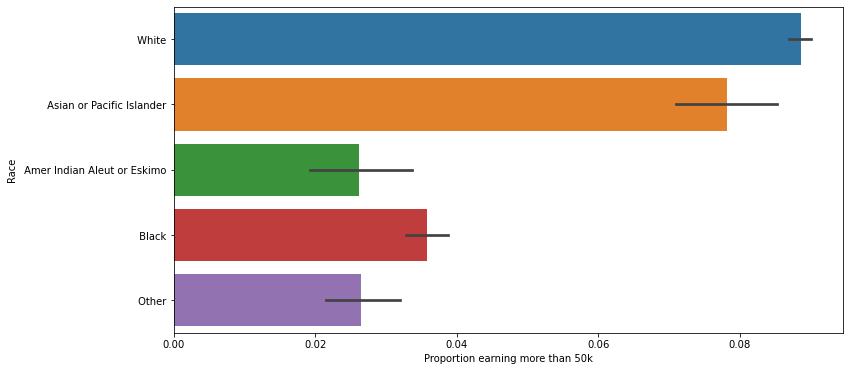

In [19]:
#Proportion earning more than 50k by race 

chart, ax = plt.subplots(figsize=(12,6))
ax = sns.barplot(y='race', x='more than 50k', data=train)
ax.set(ylabel='Race', xlabel='Proportion earning more than 50k')
plt.show()

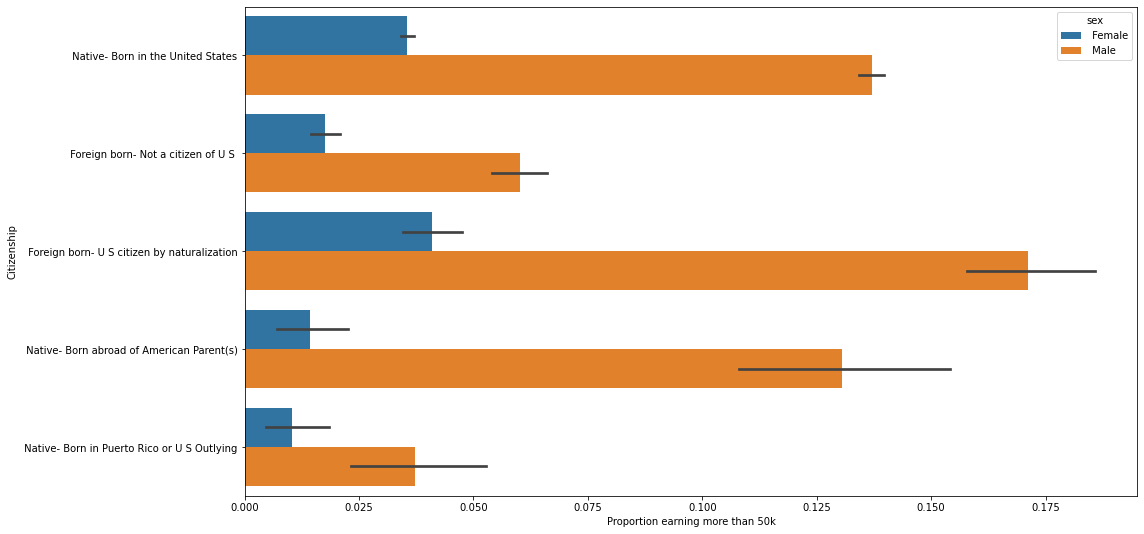

In [20]:
#Proportion earning more than 50k by citizenship and sex

chart, ax = plt.subplots(figsize=(16,9))
ax = sns.barplot(y='citizenship', x='more than 50k', hue='sex', data=train)
ax.set(ylabel='Citizenship', xlabel='Proportion earning more than 50k')
plt.show()

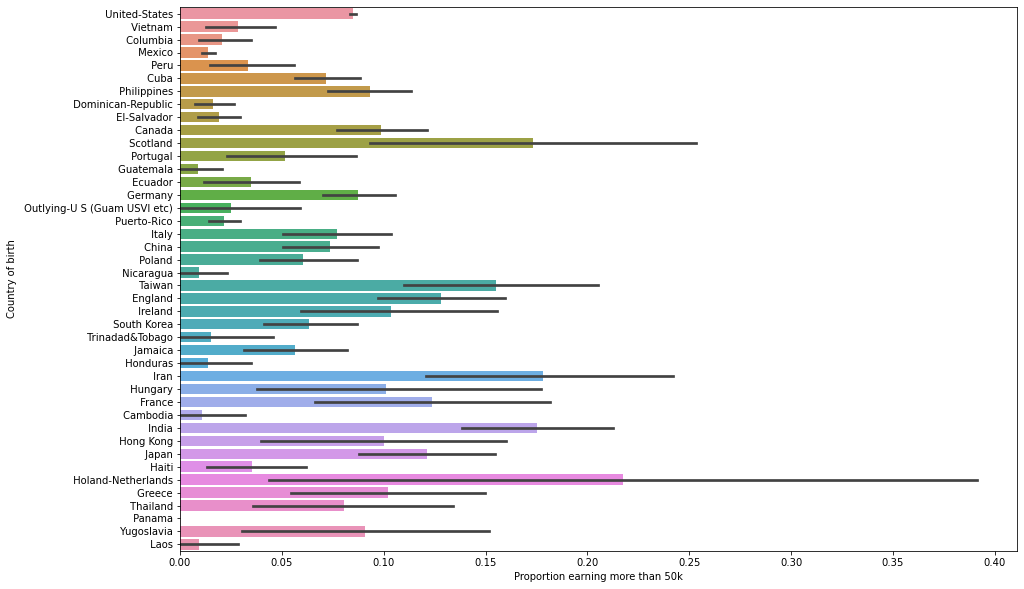

In [21]:
#Proportion earning more than 50k by country of birth

chart, ax = plt.subplots(figsize=(15,10))
ax = sns.barplot(y='country of birth self', x='more than 50k', data=train)
ax.set(xlabel='Proportion earning more than 50k', ylabel='Country of birth')
plt.show()

[Text(0, 0.5, 'Marital status'),
 Text(0.5, 0, 'Proportion earning more than 50k')]

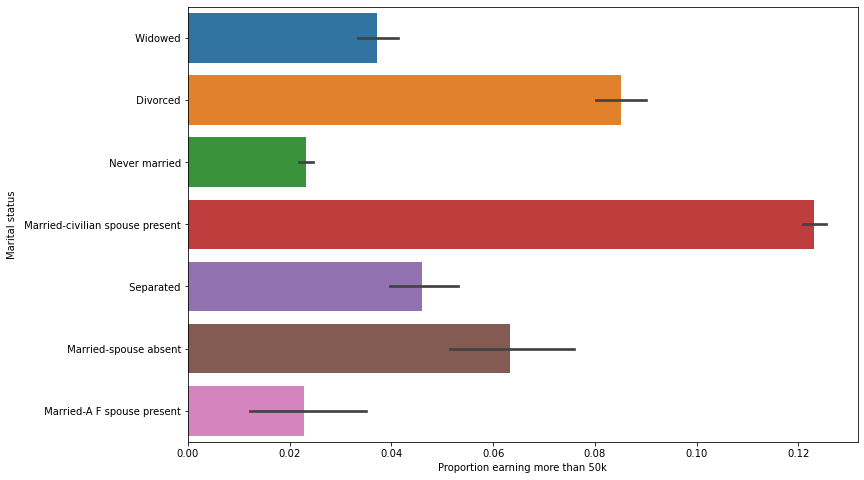

In [706]:
#Proportion earning more than 50k by marital status

chart, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(y='marital stat', x='more than 50k', data=train)
ax.set(xlabel='Proportion earning more than 50k', ylabel='Marital status')
plt.show()

In [22]:
#Descriptive statistics of continuous variables

train.describe()

,age,wage per hour,capital gains,capital losses,dividends from stocks,weeks worked in year,more than 50k
count,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000
mean,39.719371,72.324279,567.237115,48.664471,257.019255,30.061591,0.080885
std,19.662074,312.072448,5359.204656,309.511387,2261.405280,23.786471,0.272659
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,0.000000,0.000000,0.000000,0.000000,45.000000,0.000000
75%,52.000000,0.000000,0.000000,0.000000,0.000000,52.000000,0.000000
max,90.000000,9999.000000,99999.000000,4608.000000,99999.000000,52.000000,1.000000


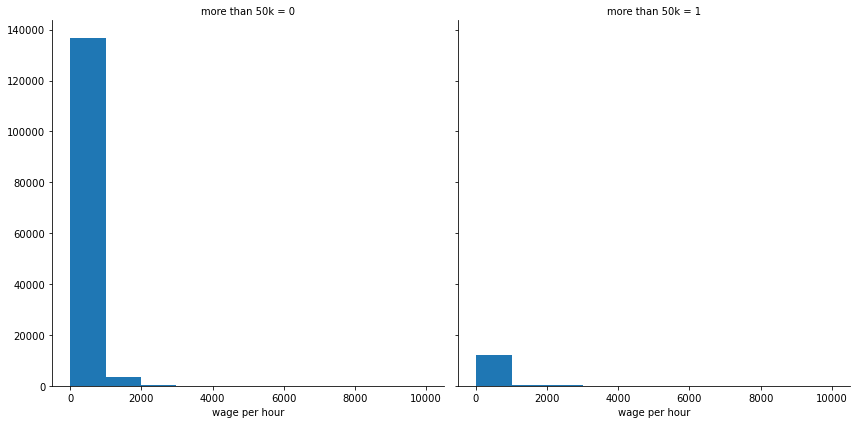

In [23]:
#Plotting histograms of wage per hour by class

g = sns.FacetGrid(train, col='more than 50k',height=6)
g = g.map(plt.hist, "wage per hour" )
plt.show()

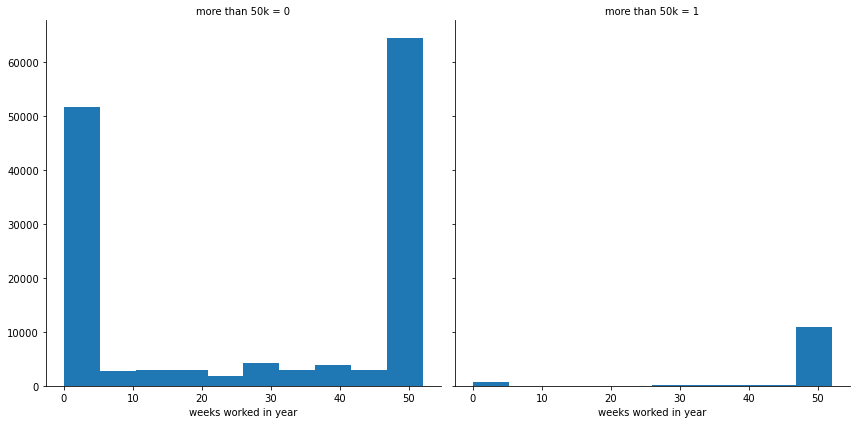

In [24]:
#Plotting histograms of weeks worked by class

g = sns.FacetGrid(train, col='more than 50k',height=6)
g = g.map(plt.hist, "weeks worked in year" )
plt.show()

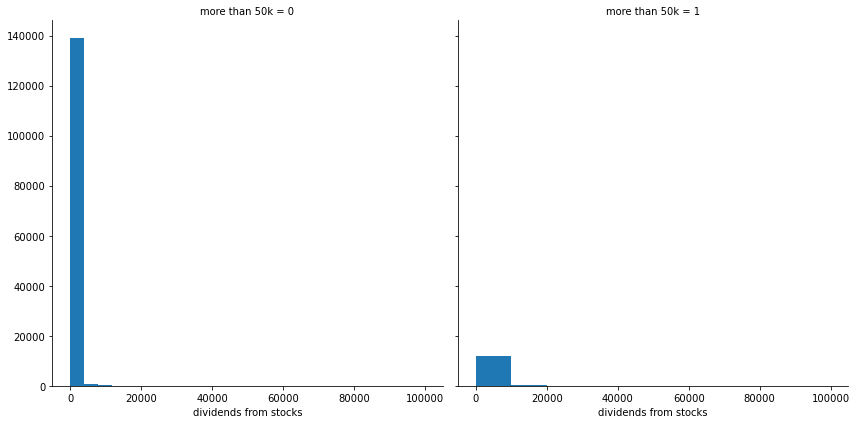

In [25]:
#Plotting histograms of dividends from stocks by class

g = sns.FacetGrid(train, col='more than 50k',height=6)
g = g.map(plt.hist, "dividends from stocks" )
plt.show()

In [26]:
#Correlation matrix

corr_matrix = train.corr().abs()
corr_matrix

,age,wage per hour,capital gains,capital losses,dividends from stocks,weeks worked in year,more than 50k
age,1.000000,0.013393,0.041409,0.040364,0.105922,0.022852,0.098788
wage per hour,0.013393,1.000000,0.006819,0.002604,0.011875,0.163749,0.008950
capital gains,0.041409,0.006819,1.000000,0.016642,0.129167,0.067444,0.236337
capital losses,0.040364,0.002604,0.016642,1.000000,0.038546,0.073113,0.138698
dividends from stocks,0.105922,0.011875,0.129167,0.038546,1.000000,0.016374,0.170304
weeks worked in year,0.022852,0.163749,0.067444,0.073113,0.016374,1.000000,0.224686
more than 50k,0.098788,0.008950,0.236337,0.138698,0.170304,0.224686,1.000000


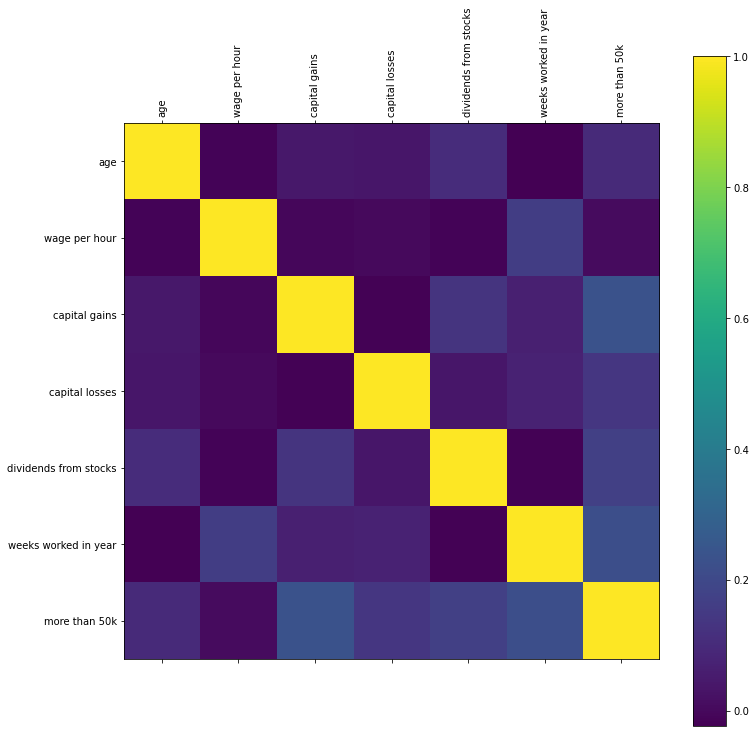

In [27]:
#Plotting the correlation matrix

matfig = plt.figure(figsize=(12,12))
plt.matshow(train.corr(), fignum=matfig.number)
plt.colorbar()
plt.xticks(np.arange(len(train.corr().columns)), train.corr().columns.values, rotation = 90) 
plt.yticks(np.arange(len(train.corr().columns)), train.corr().columns.values)
plt.show()

In [28]:
train[train['more than 50k'] == 0]['dividends from stocks'].describe()

count    140529.000000
mean        142.770688
std        1043.158036
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       39000.000000
Name: dividends from stocks, dtype: float64

In [29]:
train[train['more than 50k'] == 1]['dividends from stocks'].describe()

count    12367.000000
mean      1555.251395
std       7002.117731
min          0.000000
25%          0.000000
50%          0.000000
75%        365.000000
max      99999.000000
Name: dividends from stocks, dtype: float64

In [40]:
to_drop=['country of birth self', 'wage per hour', 'dividends from stocks']

train.drop(columns=to_drop, axis=1, inplace=True)
test.drop(columns=to_drop, axis=1, inplace=True)

In [41]:
print('Missing values counts for the training set:')
print(train.isna().sum())

print('-----------------')

print('Missing values counts for the test set:')
print(test.isna().sum())

Missing values counts for the training set:
age                      0
class of worker          0
education                0
marital stat             0
major industry code      0
major occupation code    0
race                     0
sex                      0
capital gains            0
capital losses           0
citizenship              0
weeks worked in year     0
more than 50k            0
dtype: int64
-----------------
Missing values counts for the test set:
age                      0
class of worker          0
education                0
marital stat             0
major industry code      0
major occupation code    0
race                     0
sex                      0
capital gains            0
capital losses           0
citizenship              0
weeks worked in year     0
more than 50k            0
dtype: int64


# 2. Feature Engineering

This is our dataset so far:

In [42]:
train.head()

,age,class of worker,education,marital stat,major industry code,major occupation code,race,sex,capital gains,capital losses,citizenship,weeks worked in year,more than 50k
0,73,Not in universe,High school graduate,Widowed,Not in universe or children,Not in universe,White,Female,0,0,Native- Born in the United States,0,0
1,58,Self-employed-not incorporated,Some college but no degree,Divorced,Construction,Precision production craft & repair,White,Male,0,0,Native- Born in the United States,52,0
2,18,Not in universe,10th grade,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,Female,0,0,Foreign born- Not a citizen of U S,0,0
3,9,Not in universe,Children,Never married,Not in universe or children,Not in universe,White,Female,0,0,Native- Born in the United States,0,0
4,10,Not in universe,Children,Never married,Not in universe or children,Not in universe,White,Female,0,0,Native- Born in the United States,0,0


In [43]:
#Checking attributes type

train.dtypes

age                       int64
class of worker          object
education                object
marital stat             object
major industry code      object
major occupation code    object
race                     object
sex                      object
capital gains             int64
capital losses            int64
citizenship              object
weeks worked in year      int64
more than 50k             int64
dtype: object

In [44]:
#Getting categorical and continuous features

categorical_features=[]
continuous_features=[]

for c, t in train.dtypes.items():
    if t == 'object':
        categorical_features.append(c)
    else:
        if c != 'more than 50k':
            continuous_features.append(c)

print('Categorical features:\n', categorical_features)
print('\nContinuous features:\n', continuous_features)

Categorical features:
 ['class of worker', 'education', 'marital stat', 'major industry code', 'major occupation code', 'race', 'sex', 'citizenship']

Continuous features:
 ['age', 'capital gains', 'capital losses', 'weeks worked in year']


## Ordinal Encoding

In [45]:
#Separating features and target class
X_train = train.drop(['more than 50k'], axis=1)
y_train = train['more than 50k']

X_test = test.drop(['more than 50k'], axis=1)
y_test = test['more than 50k']

#Encoding categorical variables
enc = OrdinalEncoder()
enc.fit(X_train[categorical_features])

X_train[categorical_features] = enc.transform(X_train[categorical_features])
X_test[categorical_features] = enc.transform(X_test[categorical_features])

In [46]:
#Scaling features
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [47]:
X_train.head()

,age,class of worker,education,marital stat,major industry code,major occupation code,race,sex,capital gains,capital losses,citizenship,weeks worked in year
0,1.692636,-0.515720,0.415254,2.209807,0.23866,-0.109987,0.422439,-0.970887,-0.105844,-0.157231,0.393517,-1.263815
1,0.929744,1.940126,1.307123,-1.895497,-1.61153,0.456083,0.422439,1.029986,-0.105844,-0.157231,0.393517,0.922309
2,-1.104636,-0.515720,-2.260354,0.841372,0.23866,-0.109987,-2.942463,-0.970887,-0.105844,-0.157231,-2.858936,-1.263815
3,-1.562372,-0.515720,-0.030681,0.841372,0.23866,-0.109987,0.422439,-0.970887,-0.105844,-0.157231,0.393517,-1.263815
4,-1.511512,-0.515720,-0.030681,0.841372,0.23866,-0.109987,0.422439,-0.970887,-0.105844,-0.157231,0.393517,-1.263815


## OneHot Encoding

In [48]:
#Separating features and target class
X_train_oh = train.drop(['more than 50k'], axis=1)
y_train_oh = train['more than 50k']

X_test_oh = test.drop(['more than 50k'], axis=1)
y_test_oh = test['more than 50k']

#OneHot encoding categorical features
enc = OneHotEncoder()
enc.fit(X_train[categorical_features])

cat_encoded_train = pd.DataFrame(enc.transform(X_train[categorical_features]).toarray())
cat_encoded_test = pd.DataFrame(enc.transform(X_test[categorical_features]).toarray())

X_train_oh = pd.merge(X_train_oh[continuous_features], cat_encoded_train, left_index=True, right_index=True)
X_test_oh = pd.merge(X_test_oh[continuous_features], cat_encoded_test, left_index=True, right_index=True)

In [49]:
continuous_features

['age', 'capital gains', 'capital losses', 'weeks worked in year']

In [50]:
#Scaling continuous features
scaler = StandardScaler()

X_train_oh[continuous_features] = pd.DataFrame(scaler.fit_transform(X_train_oh[continuous_features]), 
                                         columns = continuous_features)
X_test_oh[continuous_features] = pd.DataFrame(scaler.transform(X_test_oh[continuous_features]), 
                                        columns = continuous_features)

In [51]:
X_train_oh.head()

,age,capital gains,capital losses,weeks worked in year,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
0,1.692636,-0.105844,-0.157231,-1.263815,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.929744,-0.105844,-0.157231,0.922309,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-1.104636,-0.105844,-0.157231,-1.263815,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-1.562372,-0.105844,-0.157231,-1.263815,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.511512,-0.105844,-0.157231,-1.263815,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# 3. Machine learning models

In [52]:
#Printing class distribution in the datasets

print('Proportion of class 1 in the training set: {:.2f}%'.format(100*y_train.mean()))
print('Proportion of class 1 in the test set: {:.2f}%'.format(100*y_test.mean()))

Proportion of class 1 in the training set: 8.09%
Proportion of class 1 in the test set: 7.84%


The dataset is imbalanced towards the class 0. 

For every model, we look closely at the classification report (accuracy, recall, F1-score) for both training and validation. 

A great difference between validation and training results will indicate that the model is overfit.

## Baseline model - Logistic regression

Let's build a basic logistic regression model that will be the baseline for our results.

In [53]:
#Logistic regression with the Ordinal encoded dataset
lgr = LogisticRegression()
lgr.fit(X_train, y_train)

y_train_pred = lgr.predict(X_train)
y_test_pred = lgr.predict(X_test)

print('Accuracy on the training set: {:.2f}%'.format(100*accuracy_score(y_train, y_train_pred)))
print('Accuracy on the test set: {:.2f}%'.format(100*accuracy_score(y_test, y_test_pred)))

Accuracy on the training set: 92.70%
Accuracy on the test set: 92.89%


The accuracy seems good, but let's take a closer look at the model's metrics.

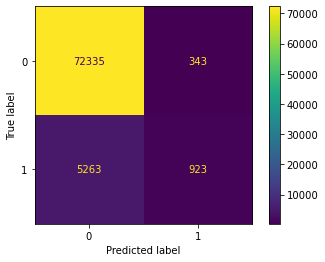

In [54]:
plot_confusion_matrix(lgr, X_test, y_test, values_format='')

In [55]:
print("Classification report with the training set")
print(classification_report(y_train, y_train_pred))

print('-------------------------------------------')

print("Classification report with the test set")
print(classification_report(y_test, y_test_pred))

Classification report with the training set
              precision    recall  f1-score   support

           0       0.93      1.00      0.96    140529
           1       0.74      0.15      0.25     12367

    accuracy                           0.93    152896
   macro avg       0.83      0.57      0.61    152896
weighted avg       0.91      0.93      0.90    152896

-------------------------------------------
Classification report with the test set
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     72678
           1       0.73      0.15      0.25      6186

    accuracy                           0.93     78864
   macro avg       0.83      0.57      0.61     78864
weighted avg       0.92      0.93      0.91     78864



<br>When the accuracy of the model seemed good at first, 
it's actually only reflecting the underlying class distribution in the data.
<br>The model performs poorly as it struggles to detect class 1 instances (0.15 recall).

Logistic regression with the **One-Hot encoded** dataset

In [46]:
#Logistic regression with the One-Hot encoded dataset
lgr = LogisticRegression(max_iter=500)
lgr.fit(X_train_oh, y_train_oh)

y_train_pred = lgr.predict(X_train_oh)
y_test_pred = lgr.predict(X_test_oh)

print('Accuracy on the training set: {:.2f}%'.format(100*accuracy_score(y_train_oh, y_train_pred)))
print('Accuracy on the test set: {:.2f}%'.format(100*accuracy_score(y_test_oh, y_test_pred)))

Accuracy on the training set: 93.49%
Accuracy on the test set: 93.79%


In [47]:
print("Classification report with the training set")
print(classification_report(y_train_oh, y_train_pred))

print('-------------------------------------------')

print("Classification report with the test set")
print(classification_report(y_test_oh, y_test_pred))

Classification report with the training set
              precision    recall  f1-score   support

           0       0.94      0.99      0.97    140529
           1       0.70      0.34      0.46     12367

    accuracy                           0.93    152896
   macro avg       0.82      0.66      0.71    152896
weighted avg       0.92      0.93      0.92    152896

-------------------------------------------
Classification report with the test set
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     72678
           1       0.72      0.35      0.47      6186

    accuracy                           0.94     78864
   macro avg       0.83      0.67      0.72     78864
weighted avg       0.93      0.94      0.93     78864



Slightly better results with the OneHot encoded data.
The model is still struggling to detect class 1 (more than 50k)

## Gaussian Naive Bayes

In [49]:
nb = GaussianNB()
nb.fit(X_train,y_train)

y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

print("Classification report with the training set")
print(classification_report(y_train, y_train_pred))

print('-------------------------------------------')

print("Classification report with the test set")
print(classification_report(y_test, y_test_pred))

Classification report with the training set
              precision    recall  f1-score   support

           0       0.94      0.97      0.95    140529
           1       0.45      0.28      0.34     12367

    accuracy                           0.91    152896
   macro avg       0.70      0.62      0.65    152896
weighted avg       0.90      0.91      0.90    152896

-------------------------------------------
Classification report with the test set
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     72678
           1       0.45      0.27      0.34      6186

    accuracy                           0.92     78864
   macro avg       0.70      0.62      0.65     78864
weighted avg       0.90      0.92      0.91     78864



## KNeighbors Classifier

In [50]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

print("Classification report with the training set")
print(classification_report(y_train, y_train_pred))

print('-------------------------------------------')

print("Classification report with the test set")
print(classification_report(y_test, y_test_pred))

Classification report with the training set
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    140529
           1       0.77      0.37      0.50     12367

    accuracy                           0.94    152896
   macro avg       0.86      0.68      0.73    152896
weighted avg       0.93      0.94      0.93    152896

-------------------------------------------
Classification report with the test set
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     72678
           1       0.69      0.32      0.44      6186

    accuracy                           0.94     78864
   macro avg       0.82      0.66      0.70     78864
weighted avg       0.92      0.94      0.92     78864



This model performs slightly better than the two previous models. For instance, it has a higher precision and recall for class 1 which is mainly what we try to improve

## Random Forest Classifier

In [51]:
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=5)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [52]:
print("Classification report with the training set")
print(classification_report(y_train, y_train_pred))

print('-------------------------------------------')

print("Classification report with the test set")
print(classification_report(y_test, y_test_pred))

Classification report with the training set
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    140529
           1       0.83      0.41      0.55     12367

    accuracy                           0.95    152896
   macro avg       0.89      0.70      0.76    152896
weighted avg       0.94      0.95      0.94    152896

-------------------------------------------
Classification report with the test set
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     72678
           1       0.76      0.37      0.49      6186

    accuracy                           0.94     78864
   macro avg       0.86      0.68      0.73     78864
weighted avg       0.93      0.94      0.93     78864



The random forest classifier seems to perfom relatively well compared to other models. We will use this model to plot the features importance as well as try random sampling techniques to handle class imbalance.

In [53]:
#Feature importance with random forest classifier
feature_importances = pd.DataFrame(rf.feature_importances_, 
                                   index=X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
capital gains,0.212942
major occupation code,0.141131
age,0.135986
education,0.118186
weeks worked in year,0.090901
sex,0.077251
major industry code,0.070393
capital losses,0.064235
class of worker,0.035586
marital stat,0.034051


# Undersampling

In [56]:
#Applying random under sampler

rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

In [57]:
#Class distribution after under sampling
y_train_under.value_counts()

1    12367
0    12367
Name: more than 50k, dtype: int64

In [58]:
#Fitting random forest model with under sampled training data

rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=5)
rf.fit(X_train_under, y_train_under)

y_train_pred = rf.predict(X_train_under)
y_test_pred = rf.predict(X_test)

In [60]:
print("Classification report with the training set")
print(classification_report(y_train_under, y_train_pred))

print('-------------------------------------------')

print("Classification report with the test set")
print(classification_report(y_test, y_test_pred))

Classification report with the training set
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     12367
           1       0.86      0.89      0.88     12367

    accuracy                           0.87     24734
   macro avg       0.88      0.87      0.87     24734
weighted avg       0.88      0.87      0.87     24734

-------------------------------------------
Classification report with the test set
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     72678
           1       0.30      0.86      0.44      6186

    accuracy                           0.83     78864
   macro avg       0.64      0.84      0.67     78864
weighted avg       0.93      0.83      0.86     78864



The classification reports show that under sampling increased the recall (ability to detect class 1) but greatly decreased class 1 accuracy. The model classifies more easily instances as class 1 (leading to an increased recall) but often wrongly classifies them as part of class 1 (leading to a decreased precision).
There is a trade-off between precision and recall.

## Oversampling

In [62]:
#Applying random over sampler

ros = RandomOverSampler(random_state=42, sampling_strategy='minority')
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)

In [63]:
#Class distribution after over sampling
y_train_over.value_counts()

1    140529
0    140529
Name: more than 50k, dtype: int64

In [64]:
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=5)
rf.fit(X_train_over, y_train_over)

y_train_pred = rf.predict(X_train_over)
y_test_pred = rf.predict(X_test)

In [65]:
print("Classification report with the training set")
print(classification_report(y_train_over, y_train_pred))

print('-------------------------------------------')

print("Classification report with the test set")
print(classification_report(y_test, y_test_pred))

Classification report with the training set
              precision    recall  f1-score   support

           0       0.96      0.91      0.93    140529
           1       0.91      0.96      0.94    140529

    accuracy                           0.94    281058
   macro avg       0.94      0.94      0.94    281058
weighted avg       0.94      0.94      0.94    281058

-------------------------------------------
Classification report with the test set
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     72678
           1       0.39      0.77      0.52      6186

    accuracy                           0.89     78864
   macro avg       0.68      0.83      0.73     78864
weighted avg       0.93      0.89      0.90     78864



In this case, over sampling can also help increasing the sensitivity of the model, but at the expense of the precision. It can also lead to overfitting.

# Summary

Here is an overview of the different steps of this analysis:
1. Loading and cleaning the data: the datasets were relatively clean, it only consisted in dropping the columns that were not relevant for the analyis, removing duplicates, and handling missing values. 
2. Performing an exploratory data analysis: some data visualisations has been plotted to gain some insights about the dataset.
3. Feature engineering: the categorical features have been encoded with 2 different methods -Ordinal encoding, and OneHot encoding- and continous features have been scaled.
4. Implementing different machine learning models and analysing their performances.
5. Trying to improve the models performance by tuning the parameters, trying out different encoding techniques, trying out under sampling and over sampling.

This analysis was the opportunity to find clear insights about this data like we saw in the EDA part or the modelling part with the random forest feature importance analysis.


The main challenges of this analysis were first to get a clear understanding of each attributes in the dataset in order to know whether they are relevant or not for the analysis. While some attributes are self explanatory, the meaning of some attributes and their context is not clear, and the metadata lacks of detailled information about each attributes (deprecated link for detailed attribute information).

Then, since the dataset is very imbalanced towards the class 'Less than 50k' (about 92% of the dataset), the challenge was to build a model that performs well in this situation. Because of this imbalance, models usually have a very high accuracy (which in fact only reflects the underlying class distribution) but actually perform quite poorly (bad recall/F1-score).
So the challenge was to build a model that has a good sensitivity (ability to detect instances of class 1). I tried some technique to handle the data's imbalance such as under sampling and over sampling to make training class distributions more even.

To sum up, many different models and preprocessing techniques can be used, leading to different results. Depending on the use case and the purpose of the analysis, for example is it more important to avoid false positives or false negatives, some models will perform better than others.